In [2]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta

sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [3]:
def concat_subsets(files):
    df = []
    for f in files:
        manyfr = pd.read_csv(f)

        manyfr = gpd.GeoDataFrame(manyfr)

        manyfr.t = manyfr.t.astype("datetime64[ns]")
        df.append(manyfr)
    df = pd.concat(df)
    return(df)

def get_lt(lt_string = "Lt_CA_Boreal_"):
    files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/" + lt_string +"*.csv")
    return(concat_subsets(files))

In [4]:
lt = get_lt() # ~ 2.9 GB

In [5]:
prov = fv.ca_prov()

In [275]:
lt.columns

Index(['Unnamed: 0', 'InterCloud', 't', 'lat', 'lon', 'current_mag',
       'multiplicity_0', 'accr', 'error_elps', 'num_station', 'geometry'],
      dtype='object')

In [280]:
# lt = lt.sjoin(prov) # Too computationally expensive??
# lt

lt = gpd.GeoDataFrame(lt, geometry = gpd.points_from_xy(lt['lon'], lt['lat']), crs = "EPSG:4326")

In [281]:
#prov.crs

lt = lt.sjoin(prov) # Too computationally expensive??
lt

,Unnamed: 0,InterCloud,t,lat,lon,current_mag,multiplicity_0,accr,error_elps,num_station,geometry,index_right,prov_name_fr,prov_name_en
362,7943712,0,2023-04-20 22:02:40.049,45.550112,-81.919713,-6855.0,0,0.0,16.0,6.0,POINT (-81.91971 45.55011),9,Ontario,Ontario
364,7973345,0,2023-04-20 22:05:31.774,45.585094,-81.920298,-7604.0,0,0.0,19.0,11.0,POINT (-81.92030 45.58509),9,Ontario,Ontario
365,7932521,0,2023-04-20 22:01:33.444,45.596547,-82.047134,-11699.0,0,0.0,27.0,3.0,POINT (-82.04713 45.59655),9,Ontario,Ontario
366,7932527,0,2023-04-20 22:01:33.469,45.603362,-82.034418,-6238.0,0,0.0,13.0,3.0,POINT (-82.03442 45.60336),9,Ontario,Ontario
368,8026915,0,2023-04-20 22:10:49.091,45.616966,-81.837416,24577.0,0,0.0,28.0,7.0,POINT (-81.83742 45.61697),9,Ontario,Ontario
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14873,1468641,0,2023-08-14 03:58:28.213,46.898948,-64.021686,-8201.0,0,0.0,7.0,5.0,POINT (-64.02169 46.89895),6,Île-du-Prince-Édouard,Prince Edward Island
14879,1520434,0,2023-08-14 04:10:28.352,46.929660,-64.008065,-24468.0,0,0.0,10.0,3.0,POINT (-64.00807 46.92966),6,Île-du-Prince-Édouard,Prince Edward Island
14900,1317413,0,2023-08-14 03:25:01.148,46.896299,-64.119554,-8317.0,0,0.0,7.0,1.0,POINT (-64.11955 46.89630),6,Île-du-Prince-Édouard,Prince Edward Island
14902,1544268,0,2023-08-14 04:15:56.188,46.926400,-64.145600,-29161.0,0,0.0,6.0,4.0,POINT (-64.14560 46.92640),6,Île-du-Prince-Édouard,Prince Edward Island


In [6]:
snap = fv.prep_gdf(date = '20230501AM',layer='perimeter',handle_multi=False,only_lf=False,area_lim=5, year = "2023", path_region = "BOREAL_NRT_3571_DPS")

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


In [7]:
snap = snap.sjoin(prov)

In [99]:
test = snap[snap.duration == 0].groupby("prov_name_en").n_pixels.sum()
test.values

array([490, 232, 248,  45,  12,   1,   9,  42,   4,  48, 318,   1])

In [80]:
#iterables = [test.index, ['20230501AM']]

#pd.MultiIndex.from_product(iterables, names=["prov", "t"])

test = pd.DataFrame(test.values, columns=["farea"], index = test.index)
test.transpose()
#test["t"] = '20230501AM'

prov_name_en,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
farea,490,232,248,45,12,1,9,42,4,48,318,1


In [76]:
#test.t.astype("datetime64[ns]")


prov_name_en,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
farea,436,196,148,45,12,9,39,4,46,202,1
t,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM


In [346]:
### To generate fire stats
date_range = pd.date_range(start = "2023-04-01 00:00:00", end = "2023-10-25 12:00:00", freq="12H")
#date_range_format = datetime.strptime(date_rage, 
date_snap = date_range.strftime("%Y%m%d%p")
date_snap
#nice_dates = date_range.strftime("%Y-%m-%d %p")

Index(['20230401AM', '20230401PM', '20230402AM', '20230402PM', '20230403AM',
       '20230403PM', '20230404AM', '20230404PM', '20230405AM', '20230405PM',
       ...
       '20231021AM', '20231021PM', '20231022AM', '20231022PM', '20231023AM',
       '20231023PM', '20231024AM', '20231024PM', '20231025AM', '20231025PM'],
      dtype='object', length=416)

In [347]:
#all_dates = lt.t.dt.strftime("%Y-%m-%d").isin(date_range.strftime("%Y-%m-%d"))
#lt[~ all_dates].t.dt.strftime("%Y-%m-%d").unique()
print(min(lt.t))
date_range[~date_range.strftime("%Y-%m-%d").isin(lt.t.dt.strftime("%Y-%m-%d"))]



2023-04-01 00:03:16.885000


DatetimeIndex(['2023-04-06 00:00:00', '2023-04-06 12:00:00',
               '2023-04-11 00:00:00', '2023-04-11 12:00:00',
               '2023-04-30 00:00:00', '2023-04-30 12:00:00',
               '2023-05-22 00:00:00', '2023-05-22 12:00:00',
               '2023-09-14 00:00:00', '2023-09-14 12:00:00',
               '2023-09-15 00:00:00', '2023-09-15 12:00:00',
               '2023-09-16 00:00:00', '2023-09-16 12:00:00',
               '2023-09-17 00:00:00', '2023-09-17 12:00:00',
               '2023-09-18 00:00:00', '2023-09-18 12:00:00',
               '2023-09-19 00:00:00', '2023-09-19 12:00:00',
               '2023-09-20 00:00:00', '2023-09-20 12:00:00',
               '2023-09-21 00:00:00', '2023-09-21 12:00:00',
               '2023-09-22 00:00:00', '2023-09-22 12:00:00',
               '2023-09-23 00:00:00', '2023-09-23 12:00:00',
               '2023-09-24 00:00:00', '2023-09-24 12:00:00',
               '2023-09-25 00:00:00', '2023-09-25 12:00:00',
               '2023-09-

In [191]:
#snap["fireID"] = snap.index
ids = snap.groupby("prov_name_en").fireID.unique()

ids

iterables = [ date_range, ['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia',
       'Ontario', 'Prince Edward Island', 'Quebec', 'Northwest Territories', 'Saskatchewan', 'Yukon']]
index = pd.MultiIndex.from_product(iterables, names=["t", "prov"])

In [192]:
index

MultiIndex([('2023-05-01 12:00:00',                   'Alberta'),
            ('2023-05-01 12:00:00',          'British Columbia'),
            ('2023-05-01 12:00:00',                  'Manitoba'),
            ('2023-05-01 12:00:00',             'New Brunswick'),
            ('2023-05-01 12:00:00', 'Newfoundland and Labrador'),
            ('2023-05-01 12:00:00',               'Nova Scotia'),
            ('2023-05-01 12:00:00',                   'Ontario'),
            ('2023-05-01 12:00:00',      'Prince Edward Island'),
            ('2023-05-01 12:00:00',                    'Quebec'),
            ('2023-05-01 12:00:00',     'Northwest Territories'),
            ('2023-05-01 12:00:00',              'Saskatchewan'),
            ('2023-05-01 12:00:00',                     'Yukon'),
            ('2023-05-02 00:00:00',                   'Alberta'),
            ('2023-05-02 00:00:00',          'British Columbia'),
            ('2023-05-02 00:00:00',                  'Manitoba'),
          

In [259]:
from datetime import date
str(date.today().strftime("%Y%m%d"))

'20231024'

In [319]:
# fire_stats = pd.DataFrame(data = [], columns=["prov_name_en", "t", "farea", "numfires", "num_active_fires",  "tot_frp", "mean_frp", "igs", "num_active_pixels", "fireID"])
# snap_list = []
# for d,n in zip(date_snap, range(0, len(date_range))):
#     print(d)
#     ## Read in 12 hour time point
#     snap = fv.prep_gdf(date = d,layer='perimeter',handle_multi=False,only_lf=False,area_lim=5, year = "2023", path_region = "BOREAL_NRT_3571_DPS")
#     snap["fireID"] = snap.index
#     snap = snap.sjoin(prov)
    
#     ## Get DF of province stats
#     fireIDs = snap.groupby(["prov_name_en", "t"]).fireID.unique().reset_index()
#     igs = snap[snap.duration == 0].groupby(["prov_name_en", "t"]).mergeid.count().reset_index()
#     igs = igs.rename(columns={"mergeid":"igs"})
    
#     num_active_pixels = snap[snap.duration == 0].groupby(["prov_name_en", "t"]).n_pixels.sum() + snap.groupby(["prov_name_en", "t"]).n_newpixels.sum()
#     num_active_pixels = num_active_pixels.reset_index()
#     num_active_pixels = num_active_pixels.rename(columns={0:"num_active_pixels"})
    
#     farea = snap.groupby(["prov_name_en", "t"]).farea.sum().reset_index()
#     numfires = snap.groupby(["prov_name_en", "t"]).mergeid.count().reset_index()
#     numfires = numfires.rename(columns={"mergeid":"numfires"})
    
#     tot_frp = snap.groupby(["prov_name_en", "t"]).meanFRP.sum().reset_index()
#     tot_frp = tot_frp.rename(columns={"meanFRP":"tot_frp"})
    
    
#     mean_frp = snap.groupby(["prov_name_en", "t"]).meanFRP.mean().reset_index()
#     mean_frp = mean_frp.rename(columns={"meanFRP":"mean_frp"})
    
    
#     ## Merge the dfs together
#     mrg = fireIDs.merge(igs, on = ['prov_name_en', 't'], how = 'outer')
#     mrg = mrg.merge(num_active_pixels, on = ['prov_name_en', 't'], how = 'outer')
#     mrg = mrg.merge(farea, on = ['prov_name_en', 't'], how = 'outer')
#     mrg = mrg.merge(numfires, on = ['prov_name_en', 't'], how = 'outer')
#     mrg = mrg.merge(tot_frp, on = ['prov_name_en', 't'], how = 'outer')
#     mrg = mrg.merge(mean_frp, on = ['prov_name_en', 't'], how = 'outer')
    
#     #snap_list.append(fireIDs)
#     fire_stats = pd.concat([fire_stats, mrg])
    
#     print(n)
#     if((n%5 == 0) | (n == (len(date_snap) -1))):
#         print(n / (len(date_snap) -1))

#         fire_stats.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/"+"boreal_snapstats_"+ str(min(date_snap)) + "_fromday_" + str(date.today().strftime("%Y%m%d")) +".csv")
#     #snap = snap[snap.t ]
# fire_stats = pd.DataFrame(data = snap_list, columns = [ "prov_name_en", "t", "fireIDs"])

In [303]:
files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats//boreal_snapstats*.csv")

fire_stats = concat_subsets(files)
#fire_stats = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/boreal_snapstats_20231024.csv")

fire_stats.num_active_fires.unique()

array([nan])

Timestamp('2023-05-30 12:00:00+0000', tz='UTC')

In [284]:
lt["t_agg"] = lt.t.dt.strftime("%Y-%m-%d %H:00:00")

In [290]:
myfr = lt.groupby(["prov_name_en", "t_agg"]).InterCloud.count().reset_index()

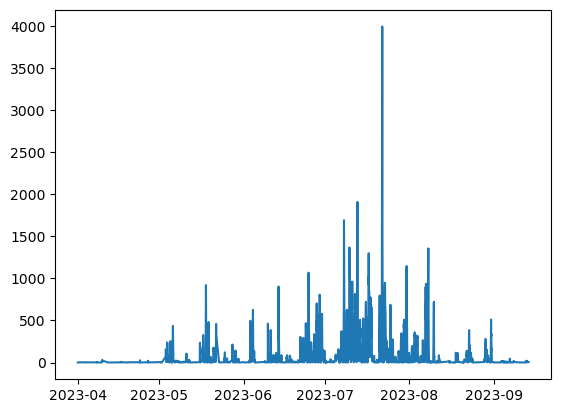

In [294]:
plt.plot(myfr[myfr.prov_name_en == 'British Columbia'].t_agg.astype("datetime64[ns]"), myfr[myfr.prov_name_en == 'British Columbia'].InterCloud)
plt.plot()

/tmp/ipykernel_3520/3653570833.py:1: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  fire_stats.t = fire_stats.t.astype("datetime64[ns]").dt.tz_localize("UTC")


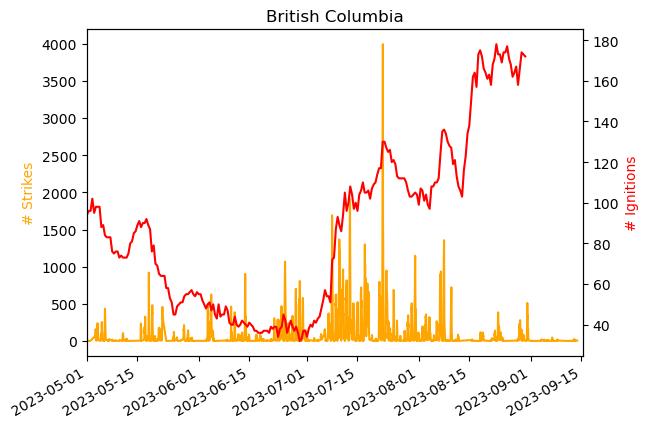

In [325]:
fire_stats.t = fire_stats.t.astype("datetime64[ns]").dt.tz_localize("UTC")

place = 'British Columbia'

fig, ax = plt.subplots()

ax.plot(myfr[myfr.prov_name_en == place].t_agg.astype("datetime64[ns]"), myfr[myfr.prov_name_en == place].InterCloud, 
        color = "orange",
        label= "Lightning")
ax.set_ylabel("# Strikes", color = "orange")
ax.set_title(place)
#ax.legend()
ax2.set_xlim(min(date_range), max(date_range))
ax2 = ax.twinx()
ax2.plot(fire_stats[fire_stats.prov_name_en == place].t, (fire_stats[fire_stats.prov_name_en == place].igs), color = "red", label = "Ignitions")
#ax2.legend()
ax2.set_ylabel("# Ignitions", color = "red")
ax2.set_xlim(min(date_range), max(date_range))
fig.autofmt_xdate()

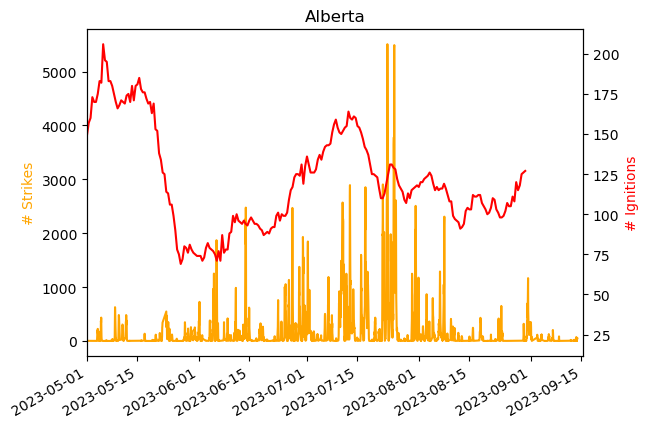

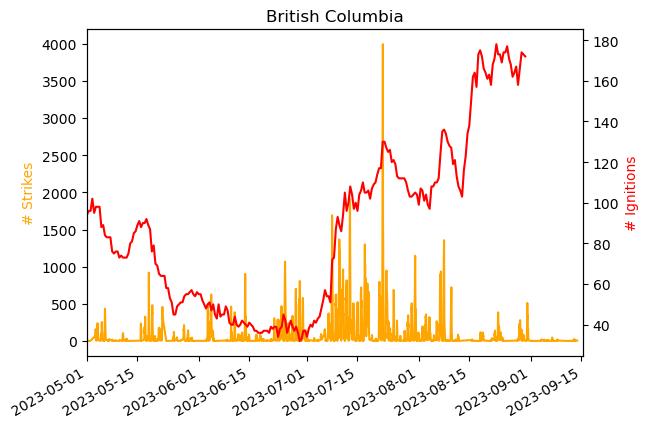

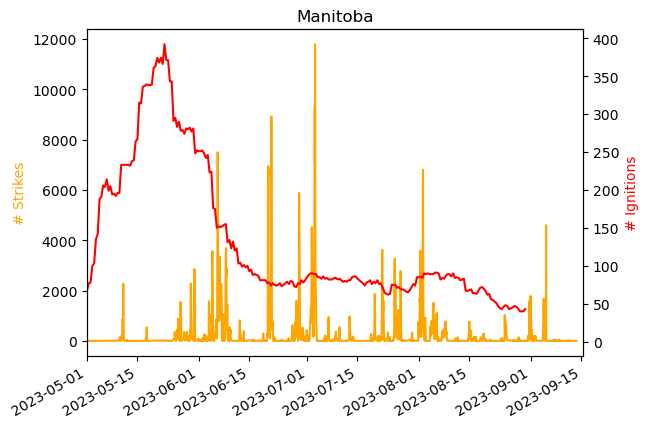

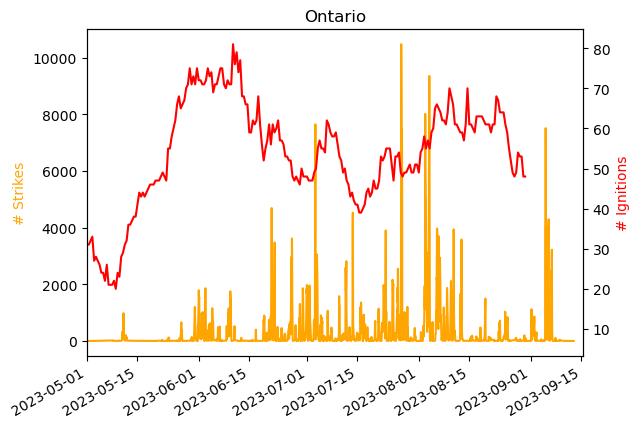

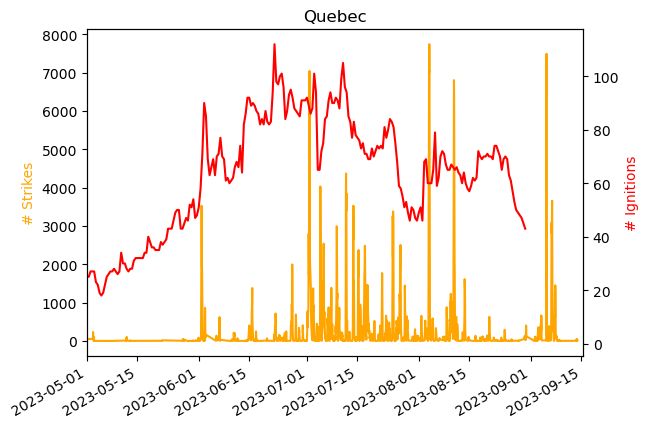

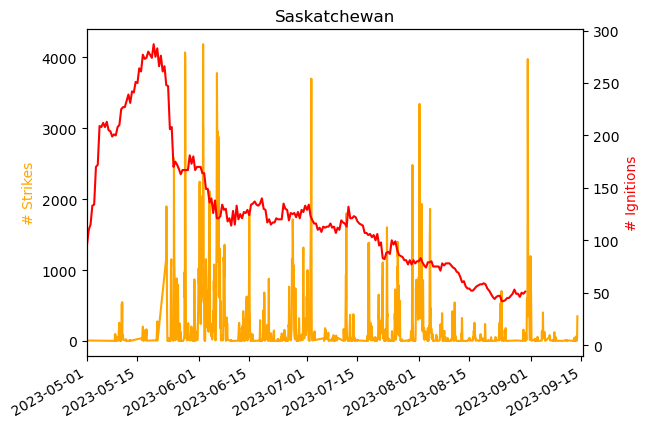

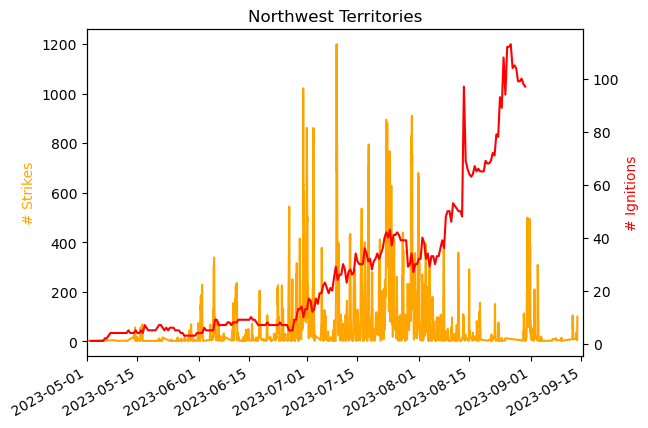

In [327]:
places = fire_stats.prov_name_en.unique()

for place in places:
    if(max(fire_stats[fire_stats.prov_name_en == place].igs) <= 50):
        continue
    fig, ax = plt.subplots()
    ax.plot(myfr[myfr.prov_name_en == place].t_agg.astype("datetime64[ns]"), myfr[myfr.prov_name_en == place].InterCloud, 
            color = "orange",
            label= "Lightning")
    ax.set_ylabel("# Strikes", color = "orange")
    ax.set_title(place)
    #ax.legend(loc = 0)
    ax2.set_xlim(min(date_range), max(date_range))
    ax2 = ax.twinx()
    ax2.plot(fire_stats[fire_stats.prov_name_en == place].t, (fire_stats[fire_stats.prov_name_en == place].igs), color = "red", label = "Ignitions")
    #ax2.legend()
    ax2.set_ylabel("# Ignitions", color = "red")
    ax2.set_xlim(min(date_range), max(date_range))
    fig.autofmt_xdate()
    

In [291]:
myfr.columns

Index(['prov_name_en', 't_agg', 'InterCloud'], dtype='object')

In [317]:
lt.t.min()

Timestamp('2023-04-01 00:03:16.885000')